# 面部识别
一般关于什么内容的网络都命名为...Net或者deep...，比如关于面部识别的就是FaceNet以及DeepFace。

面部识别问题一般分为两类：人脸检测（1:1匹配问题）和人脸识别（1：k识别问题）

FaceNet通过神经网络学习，将人脸照片编码成128维向量，通过比较两个向量来判断，两张照片是否是同一个人。

这一节中，将学会实现triplet loss函数，以及使用预训练好的模型来映射128维的照片，以及使用这些编码好的照片来运行人脸检测以及人脸识别

关于视频中说到，对一个照片进行编码时，有可能通道数在后面，也可能在前面，这一节我们统一约定通道数在前，所以对于一个batch的维度是(m, n_C, n_H, n_W)。


CV2是OpenCV官方的一个扩展库,里面含有各种有用的函数以及进程。 OpenCV的全称是:Open Source Computer Vision Library计算机视觉开源库。安装这个库的方法是直接安装opencv，并且是在网上下.whl的文件，如果是python2和python3的环境都有的话，应该在python3的环境下进行安装，进行上面这个文件所在的目录，使用pip install ...(文件名.whl)，安装好以后我这上面报错，报错信息是：找不到DLL，解决办法是下了个vs2015安装了，以及在3的环境中放了python3.dll文件。

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer

from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


## 0 简单人脸验证
给定两张照片，判断是不是同一个人，最简单的方法就是比较两张图片的像素，计算欧氏距离如果小于某个阈值，就认为是同一个人。
![两张图片判断是否是一个人](https://upload-images.jianshu.io/upload_images/1779926-fe29b97d57bd062e.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

当然，这个算法表现的很差，因为像素值可能会很局灯光，角度等问题变化，或者镜子也会变化位置等。所以会发现不应该直接使用原图，而是学习一个f(img)函数，让这个函数为图片生成一个新的更准确的编码，最后用这个编码来判断是否是一个人。

## 1. 把人脸照片编码为128维向量

### 1.1 使用卷积网络来计算编码
FaceNet需要很多的数据和很长时间来训练，所以跟随常规操作在实际深度学习的应用，直接加载别人已经训练好的权重。这个网络模型使用inception模型。inception_blocks.py 文件中可以查看inception模型是如何实现的。

关键要记住的：
- 这个网络使用的是96\*96的RGB图像作为输入。所以根据对应的要求，应该修改为 $(m, n_C, n_H, n_W) = (m, 3, 96, 96)$ 
- 输出应该是（m，128）维的矩阵，将每一张图片编码成128维向量


In [2]:
# faceRecoModel是写在inception_blocks.py里的一个函数，只需要输入X的维度，就可以自己创建x张量，并且中间搭建了一系列的网络架构
#网络的最后一层是128个隐藏单元，所以最后就创建好了这个模型，所以这个函数就是返回一个模型
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

#使用FRmodel变量接收这个模型

出现问题，l2_normalize() got an unexpected keyword argument 'axis'，看网上有类似的问题说是tensorflow的版本问题导致的，所以就准备安装新的包版本，但是一个环境只能有一套包，可是又不想卸载之前的想安装两种版本，所以就需要安装虚拟环境，安装方法如下：
```python
# 安装虚拟环境
pip install virtualenv
pip install virtualenvwrapper-win

# 创建一个虚拟环境，后面是可以自己任意取名字的
mkvirtualenv tf-cpu-1.6.0
#进入虚拟环境工作区
workon  tf-cpu-1.6.0
#在虚拟环境下安装新的tensorflow的包
pip install tensorflow==1.6.0

#安装虚拟环境后，一个工程要在某个指定的虚拟环境下工作时，环境间的包不是共享的，那么就得完整的给虚拟环境安装一套，最后还是决定重新安装
```

最后通过各种看官方文档，可能是tensorflow的版本问题，但是也没有找着具体应该用哪个版本，因为tf.nn.l2_normalization(x，axis)这个方法后来的传入参数里面已经没有axis这个参数了，取而代之的是dim这个参数，但是是一样的意思，都表示对前面x这个张量按某个维度进行l2正则化，而在keras的包里面，调用了tf.nn.l2_normalization这个方法，找到文件修改参数名字即可。总的来说，方案就是：
```
到报错的那个文件，我的是这个D:\softpath\Anaconda2\envs\py3\Lib\site-packages\keras\backend\tensorflow_backend.py
将里面return tf.nn.l2_normalize(x, axis=axis) 修改为
return tf.nn.l2_normalize(x, dim=axis)
```

In [3]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


通过使用128神经元的全连接层作为最后一层，这个模型保证了输出还是一个编码为128维的向量。然后就是用两张图片都输入这个网络中产生的128维向量进行比较判断是否是同一个人。
![人脸检测原理](https://upload-images.jianshu.io/upload_images/1779926-ba51e06397e1e1b5.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)


### 1.2 triplet loss
使用某人的两张照片与一张非本人照片，去训练网络，损失的定义原理就是根据，同一个的照片计算出来的128维向量距离会很近，而不是同一个人计算出来的距离会很远，所以d(A,P)-d(A,N)\<0,d()函数的计算方式是两个向量对应元素之差的平方和。如果这个差值小于某个值，则说明模型判断anchor是不是本人还是很有用的。
Anchor (A), Positive (P), Negative (N) 

![triplet loss定义原理](https://upload-images.jianshu.io/upload_images/1779926-ed3fecc8f5c80583.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

![triplet loss计算公式](https://upload-images.jianshu.io/upload_images/1779926-9c67c8586d1aa498.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

α is called the margin. It is a hyperparameter that you should pick manually. We will use α=0.2.

**Exercise**: Implement the triplet loss as defined by formula (3). Here are the 4 steps:
1. Compute the distance between the encodings of "anchor" and "positive": $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$
2. Compute the distance between the encodings of "anchor" and "negative": $\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$
3. Compute the formula per training example: $ \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$
3. Compute the full formula by taking the max with zero and summing over the training examples:
$$\mathcal{J} = \sum^{N}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+ \tag{3}$$

Useful functions: `tf.reduce_sum()`, `tf.square()`, `tf.subtract()`, `tf.add()`, `tf.reduce_mean`, `tf.maximum()`.

In [4]:
#定义triplet loss 函数
# GRADED FUNCTION: triplet_loss

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(y_pred[0],y_pred[1])),axis=-1)
    """
    L2范数是我们最常见最常用的范数了，我们用的最多的度量距离欧氏距离就是一种L2范数,表示向量元素的平方差再求和
    tf.subtract对应元素相减，tf.square每个元素求平方值  tf.reduce_sum可以指定在某维度上求和
    """ 
    
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(y_pred[0],y_pred[2])),axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss =  tf.reduce_sum(tf.maximum(basic_loss,0.0))
    ### END CODE HERE ###
    
    return loss

In [5]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

loss = 528.1432


## 2. 加载已经训练好的模型
FaceNet是使用最小化triple loss来训练的。但是因为训练需要一些数据以及一些计算，所以我们只加载了模型，现在需要花时间编译一下。

In [6]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

## 3. 应用这个模型
现在对这个幸福公寓，不想任何人都能进来，所以要建立人脸验证系统，只能放一些特定的人进来。为了进公寓，每一个人都必须携带一个ID card。

### 3.1 人脸验证
首先建立一个数据库来存放一个可以被允许进入的人的编码好的向量。为了生成编码，我们使用img_to_encoding(image_path, model)这个函数，是在模型的前向传播的基础上运行的，针对某一张特定的图片。

运行下面代码来创建一个数据库，使用一个python字典来表示。这个数据集就把每一个人的名字对应为一个128维的向量，并且存放起来了。

In [10]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)
database["tudou"] = img_to_encoding("images/tudou1.jpg", FRmodel)

In [7]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
print(database)

{'danielle': array([[ 0.11276133,  0.03207601,  0.13590078,  0.11822379,  0.07636504,
         0.13431978,  0.14880915, -0.13990873, -0.01258973, -0.06264802,
        -0.06895615,  0.05656987, -0.00625059,  0.00522547,  0.07190287,
        -0.05568053,  0.04310033,  0.04391421, -0.04496383, -0.0464243 ,
        -0.00843207,  0.12305687, -0.0955635 ,  0.17989582,  0.01794844,
        -0.10260746, -0.14342976, -0.03599926, -0.04165843,  0.13982902,
        -0.04188614,  0.11941336, -0.12171154,  0.05106764,  0.08596217,
        -0.05465613,  0.08568984, -0.06256222,  0.00192188, -0.03967048,
         0.1094245 ,  0.00864273,  0.06470723, -0.19549362, -0.03102044,
         0.05460501,  0.00480903, -0.02807491, -0.02172411, -0.03455152,
         0.150454  , -0.07591686,  0.16888484,  0.01827822,  0.10440756,
         0.02885913, -0.00706925,  0.07838197,  0.01713117,  0.01476892,
         0.01493397,  0.11768679, -0.09003265, -0.18028447,  0.06014766,
         0.08900282,  0.06730765, -0.0

In [11]:
print(len(database))

13


实现verify()函数来检查门前照相机拍到的图片是否是这个人，并且是这个名字。
1. 计算门前拍到的照片的编码
2. 计算数据库里的编码和门前照片编码的距离。
3. 如果距离小于0.7，那么久打开门，否则不打开


In [12]:
# GRADED FUNCTION: verify

def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be a resident of the Happy house.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    
    ### START CODE HERE ###
    
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding(image_path, FRmodel)
    
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding-database[identity])
    
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist<0.7:
        print("It's " + str(identity) + ", welcome home!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
        
    ### END CODE HERE ###
        
    return dist, door_open

In [13]:
#对某个要进来的人进行测试
verify("images/camera_0.jpg", "younes", database, FRmodel)

It's younes, welcome home!


(0.65939283, True)

In [14]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

It's not kian, please go away


(0.86224014, False)

In [18]:
verify("images/tudou.jpg", "tudou", database, FRmodel)

It's tudou, welcome home!


(0.5812857, True)

### 3.2 人脸识别
你的人脸验证系统工作的很好，但是如果一个人的身份证被偷了，那他就没法进入了，因为无法进行身份验证。为了解决这个问题，就需要把人脸验证系统改为人脸识别系统，就不用需要身份证了。

现在要实现人脸识别，需要的输入仅仅是一张照片，并且计算出来是否是已经通过验证的某一个人。与人脸验证不同的是，我们不需要再知道这个人的身份作为输入。

实现who_is_it():
1. 计算目标输入图像的128维编码
2. 从数据库中找到这个目标编码距离最近的一个编码：
   - 初始化min_dist变量为一个比较大的数，它能跟踪找到距离目标编码最近的编码
   - 在数据库字典名字和编码中循环，loop use for (name, db_enc) in database.items().
        - 计算L2距离
        - 如果这个距离比min-dist小，就把min-dist设置到字典中，并且标识姓名

In [19]:
# GRADED FUNCTION: who_is_it

def who_is_it(image_path, database, model):
    """
    Implements face recognition for the happy house by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    ### START CODE HERE ### 
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_to_encoding(image_path, FRmodel)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding-db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist<min_dist:
            min_dist = dist
            identity = name
    """
    这里首先初始化min_dist最小距离为一个比较大的数，那么在循环的时候，跟第一个人比较，如果距离比这个min还大，说明不是这个人，不理会，继续循环
    如果循环到某个人，两人小于min，那么久把min修改为当前的距离，并且记住名字，但是并不能说明就是这个人，可能只是很像，那么继续循环
    直到把所有人都循环完毕，那么久找到了数据库里所有人中跟目标最像的一个，但是并不能判断是，要根据这个min距离来跟阈值比较，最后确定是不是这个人
    """

    ### END CODE HERE ###
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [20]:
who_is_it("images/camera_0.jpg", database, FRmodel)

it's younes, the distance is 0.65939283


(0.65939283, 'younes')

In [21]:
who_is_it("images/camera_1.jpg", database, FRmodel)

it's bertrand, the distance is 0.46768054


(0.46768054, 'bertrand')

In [23]:
who_is_it("images/tudou1.jpg", database, FRmodel)

it's tudou, the distance is 0.5812857


(0.5812857, 'tudou')

现在你的幸福公寓大门只对已经验证过的人开放了，人们也不再需要携带身份证了。

后面的内容这节内容不会再实现了，但是你可以自己去提高你的算法从下面这些方面：
1. 放入更多人的照片，在不同的光线角度下，或者不同的天气下，然后给定一个图，去跟很多的图进行比较。

2. 裁剪图像只包含脸部，而脸部周围的“边界”区域较少。这种预处理消除了人脸周围的一些不相关的像素，并使算法更健壮。


记住：
- 人脸验证解决1:1问题，人脸识别解决1：k的问题
- triplet是一个有效的损失函数去训练神经网络学习面部图片的编码
- 同样的编码可以用在验证和识别上，通过距离去判断是否是一个人

In [24]:
FRmodel.summary() 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 102, 102)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

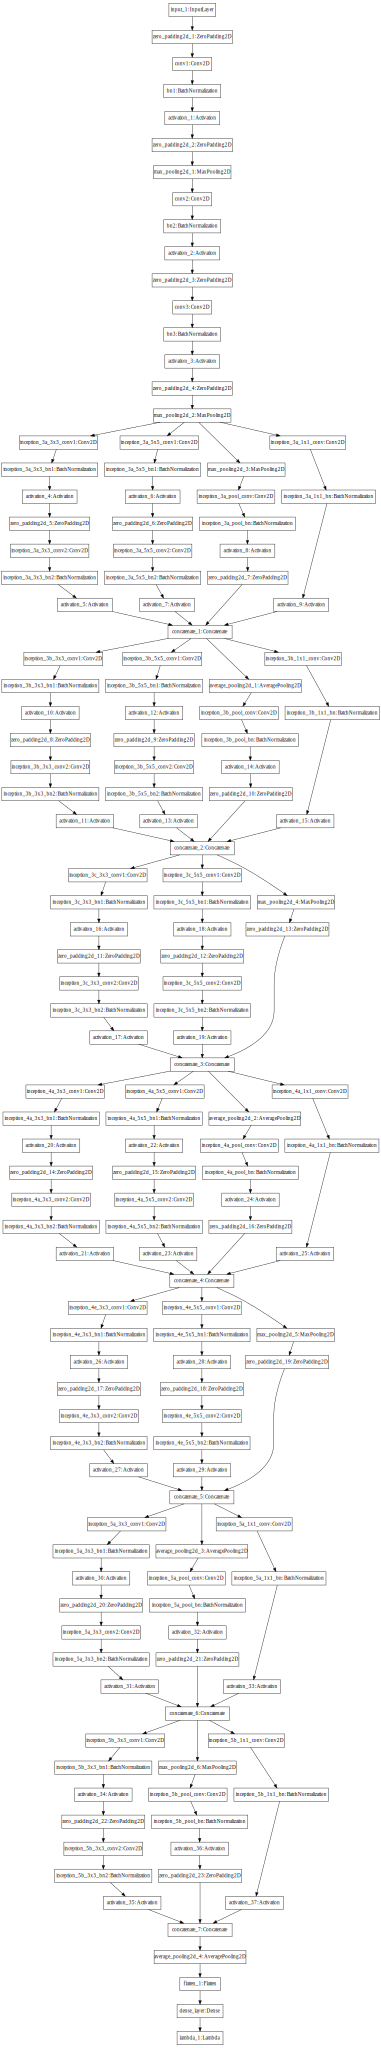

In [25]:
plot_model(FRmodel, to_file='model.png')
SVG(model_to_dot(FRmodel).create(prog='dot', format='svg'))